Name: Ajit Dinkar Bhandarkar<br>
ID: 5151239901<br>
Github: Ajit-Dinkar-Bhandarkar<br>
<b>Final Project<b>


### Importing Libraries and Data

In [2]:

import os, shutil, random, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import warnings, logging, os
import logging
from absl import logging as absl_logging
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_fscore_support)
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, ResNet101, VGG16, EfficientNetB0
from tensorflow.keras.applications import resnet, efficientnet, vgg16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

warnings.filterwarnings('ignore')
logging.getLogger('absl').setLevel(logging.ERROR)


PREPROCESS_FN = {
    'ResNet50'       : resnet.preprocess_input,
    'ResNet101'      : resnet.preprocess_input,
    'VGG16'          : vgg16.preprocess_input,
    'EfficientNetB0' : efficientnet.preprocess_input
}

def build_datagen(model_type, augment=True):

    if augment:
        return ImageDataGenerator(
            preprocessing_function = PREPROCESS_FN[model_type],
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    return ImageDataGenerator(preprocessing_function = PREPROCESS_FN[model_type])


IMG_HEIGHT = 224
IMG_WIDTH  = 224
BATCH_SIZE = 5
NUM_CLASSES = 9


### Mounting Drive

In [3]:

from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/RealWaste'

class_names = [
    '1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal',
    '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation'
]

assert os.path.exists(data_dir), f"Data directory not found: {data_dir}"
print("Data directory verified ")


for cname in class_names:
    n = len([f for f in os.listdir(os.path.join(data_dir, cname))
             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))])
    print(f"{cname:25s}: {n}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data directory verified 
1-Cardboard              : 461
2-Food Organics          : 411
3-Glass                  : 420
4-Metal                  : 790
5-Miscellaneous Trash    : 495
6-Paper                  : 500
7-Plastic                : 921
8-Textile Trash          : 318
9-Vegetation             : 436


### Data Splitting

In [3]:

dataset_dir = '/content/waste_dataset'
train_dir, val_dir, test_dir = [os.path.join(dataset_dir, x) for x in ('train','val','test')]

for d in (train_dir, val_dir, test_dir):
    os.makedirs(d, exist_ok=True)
    for cname in class_names:
        os.makedirs(os.path.join(d, cname), exist_ok=True)

def split_and_copy(class_name):
    src = os.path.join(data_dir, class_name)
    imgs = sorted([f for f in os.listdir(src)
                   if f.lower().endswith(('.png','.jpg','.jpeg','.gif','.bmp'))])
    n = len(imgs)
    n_train = int(0.8 * n)
    n_train_actual = int(0.8 * n_train)
    train_imgs = imgs[:n_train_actual]
    val_imgs   = imgs[n_train_actual:n_train]
    test_imgs  = imgs[n_train:]

    for f in train_imgs: shutil.copy2(os.path.join(src,f), os.path.join(train_dir,class_name,f))
    for f in val_imgs:   shutil.copy2(os.path.join(src,f), os.path.join(val_dir,class_name,f))
    for f in test_imgs:  shutil.copy2(os.path.join(src,f), os.path.join(test_dir,class_name,f))

    return len(train_imgs), len(val_imgs), len(test_imgs)

print("Splitting images …")
for cname in class_names:
    tr, va, te = split_and_copy(cname)
    print(f"{cname:25s}: {tr} train | {va} val | {te} test")


Splitting images …
1-Cardboard              : 294 train | 74 val | 93 test
2-Food Organics          : 262 train | 66 val | 83 test
3-Glass                  : 268 train | 68 val | 84 test
4-Metal                  : 505 train | 127 val | 158 test
5-Miscellaneous Trash    : 316 train | 80 val | 99 test
6-Paper                  : 320 train | 80 val | 100 test
7-Plastic                : 588 train | 148 val | 185 test
8-Textile Trash          : 203 train | 51 val | 64 test
9-Vegetation             : 278 train | 70 val | 88 test


In [4]:

def show_augmented(model_type='ResNet50', n_images=9):
    gen = build_datagen(model_type, augment=True).flow_from_directory(
        train_dir, target_size=(IMG_HEIGHT,IMG_WIDTH),
        batch_size=1, class_mode='categorical', shuffle=True
    )
    plt.figure(figsize=(10,8))
    for i in range(n_images):
        img, label = next(gen)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(img[0]); plt.axis('off')
        plt.title(class_names[np.argmax(label[0])], fontsize=8)
    plt.tight_layout(); plt.show()




### Creating a Model with required Layers

In [5]:
def create_model(base,
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                 num_classes=NUM_CLASSES,
                 hidden_units=256):

    if base == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base == 'ResNet101':
        base_model = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base == 'EfficientNetB0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unknown backbone")

    base_model.trainable = False


    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)


    x = Dense(hidden_units, activation='relu')(x)


    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_regularizer=l2(0.01))(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


### Training the required Models

In [6]:

def train_and_evaluate_model(model_type, epochs=100):

    train_gen = build_datagen(model_type, augment=True).flow_from_directory(
        train_dir, target_size=(IMG_HEIGHT,IMG_WIDTH), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True)
    val_gen   = build_datagen(model_type, augment=False).flow_from_directory(
        val_dir, target_size=(IMG_HEIGHT,IMG_WIDTH), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False)
    test_gen  = build_datagen(model_type, augment=False).flow_from_directory(
        test_dir, target_size=(IMG_HEIGHT,IMG_WIDTH), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False)

    model = create_model(model_type)

    cb_early = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True,start_from_epoch=50)
    cb_ckpt  = ModelCheckpoint(f'best_{model_type}.h5', monitor='val_loss',
                               save_best_only=True, mode='min', verbose=1)

    history = model.fit(train_gen, epochs=epochs,
                        validation_data=val_gen,
                        callbacks=[cb_early, cb_ckpt], verbose=2)


    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(history.history['loss'], label='train'); plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{model_type} – Loss'); plt.xlabel('epoch'); plt.legend()
    plt.subplot(1,2,2); plt.plot(history.history['accuracy'], label='train'); plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{model_type} – Accuracy'); plt.xlabel('epoch'); plt.legend()
    plt.tight_layout(); plt.show()


    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    preds_proba = model.predict(test_gen, verbose=0)
    preds = np.argmax(preds_proba, axis=1)
    y_true = test_gen.classes

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, preds, average='weighted', zero_division=0)

    print(f'\n{model_type} – Test acc: {test_acc:.4f}  |  F1-score: {f1:.4f}')
    print(classification_report(y_true, preds, target_names=class_names, zero_division=0))


    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_matrix(y_true,preds), annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_type} – Confusion Matrix')
    plt.ylabel('True'); plt.xlabel('Predicted'); plt.tight_layout(); plt.show()


    lb = LabelBinarizer().fit(range(NUM_CLASSES))
    y_bin = lb.transform(y_true)
    plt.figure(figsize=(10,8))
    aucs = []
    for i in range(NUM_CLASSES):
        fpr,tpr,_ = roc_curve(y_bin[:,i], preds_proba[:,i])
        roc_auc = auc(fpr,tpr); aucs.append(roc_auc)
        plt.plot(fpr,tpr,label=f'{class_names[i][:3]} (AUC={roc_auc:.2f})')
    plt.plot([0,1],[0,1],'k--'); plt.xlim(0,1); plt.ylim(0,1.05)
    plt.title(f'{model_type} – ROC curves'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

    return dict(model_type=model_type, test_accuracy=test_acc,
                precision=precision, recall=recall, f1_score=f1,
                mean_auc=np.mean(aucs))



Training ResNet50
Found 3034 images belonging to 9 classes.
Found 764 images belonging to 9 classes.
Found 954 images belonging to 9 classes.
Epoch 1/100

Epoch 1: val_loss improved from inf to 1.86896, saving model to best_ResNet50.h5
607/607 - 64s - 105ms/step - accuracy: 0.5906 - loss: 1.6754 - val_accuracy: 0.6374 - val_loss: 1.8690
Epoch 2/100

Epoch 2: val_loss improved from 1.86896 to 1.31450, saving model to best_ResNet50.h5
607/607 - 44s - 73ms/step - accuracy: 0.7238 - loss: 0.9750 - val_accuracy: 0.6937 - val_loss: 1.3145
Epoch 3/100

Epoch 3: val_loss improved from 1.31450 to 1.27582, saving model to best_ResNet50.h5
607/607 - 44s - 72ms/step - accuracy: 0.7663 - loss: 0.7713 - val_accuracy: 0.7016 - val_loss: 1.2758
Epoch 4/100

Epoch 4: val_loss did not improve from 1.27582
607/607 - 44s - 72ms/step - accuracy: 0.7841 - loss: 0.6845 - val_accuracy: 0.6911 - val_loss: 1.2879
Epoch 5/100

Epoch 5: val_loss improved from 1.27582 to 1.25071, saving model to best_ResNet50.h5


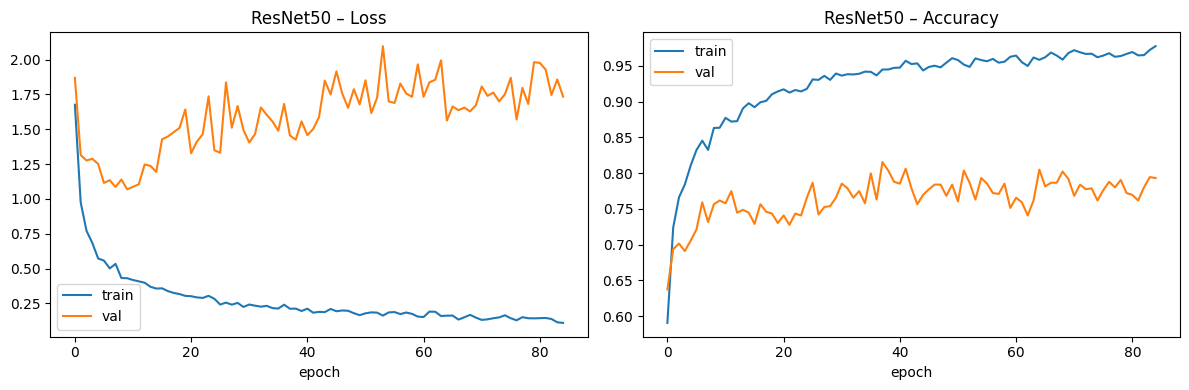


ResNet50 – Test acc: 0.7767  |  F1-score: 0.7736
                       precision    recall  f1-score   support

          1-Cardboard       0.85      0.86      0.86        93
      2-Food Organics       0.82      0.66      0.73        83
              3-Glass       0.67      0.71      0.69        84
              4-Metal       0.73      0.87      0.80       158
5-Miscellaneous Trash       0.71      0.53      0.60        99
              6-Paper       0.88      0.88      0.88       100
            7-Plastic       0.74      0.76      0.75       185
      8-Textile Trash       0.78      0.72      0.75        64
         9-Vegetation       0.88      0.93      0.91        88

             accuracy                           0.78       954
            macro avg       0.78      0.77      0.77       954
         weighted avg       0.78      0.78      0.77       954



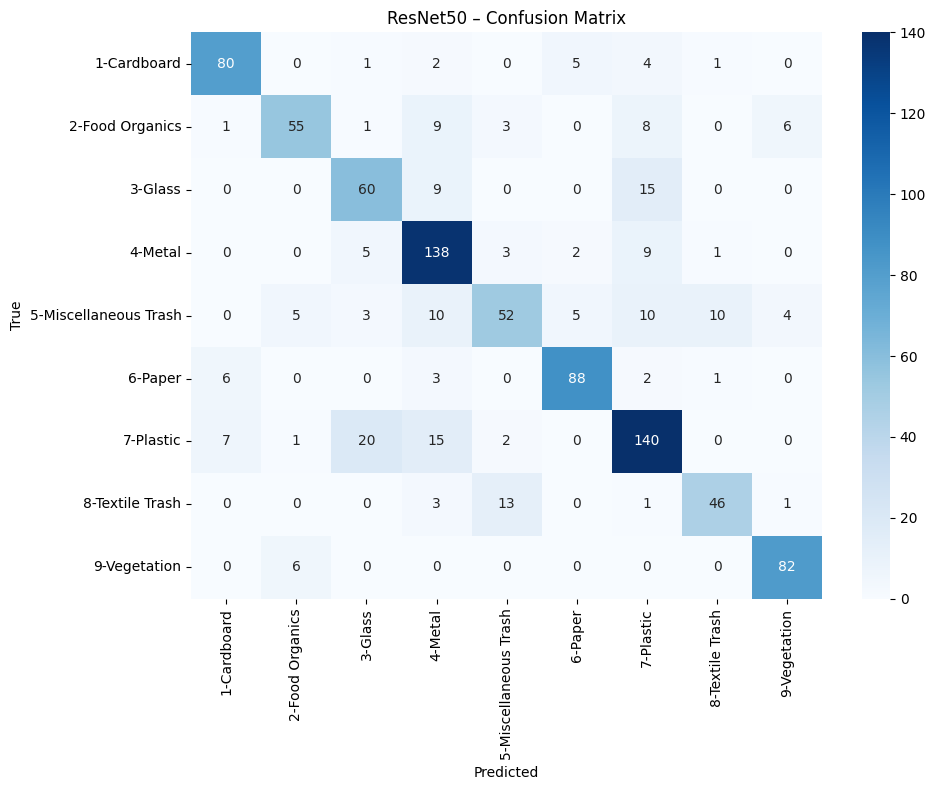

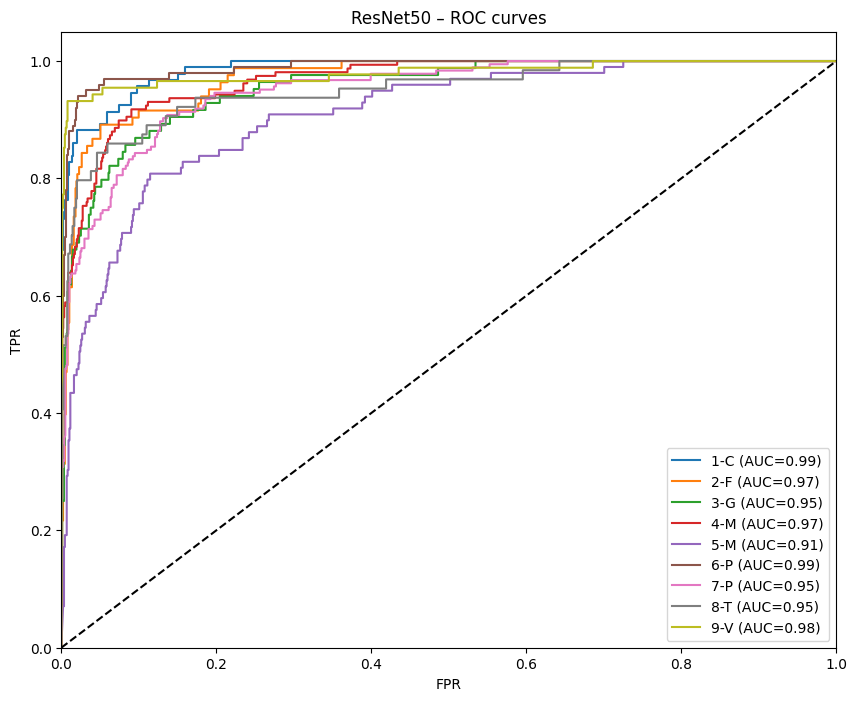


Training ResNet101
Found 3034 images belonging to 9 classes.
Found 764 images belonging to 9 classes.
Found 954 images belonging to 9 classes.
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Epoch 1/100

Epoch 1: val_loss improved from inf to 1.57745, saving model to best_ResNet101.h5
607/607 - 81s - 133ms/step - accuracy: 0.6002 - loss: 1.6369 - val_accuracy: 0.6754 - val_loss: 1.5775
Epoch 2/100

Epoch 2: val_loss improved from 1.57745 to 1.42221, saving model to best_ResNet101.h5
607/607 - 47s - 77ms/step - accuracy: 0.7212 - loss: 0.9613 - val_accuracy: 0.6963 - val_loss: 1.4222
Epoch 3/100

Epoch 3: val_loss improved from 1.42221 to 1.14500, saving model to best_ResNet101.h5
607/607 - 46s - 76ms/step - accuracy: 0.7848 - loss: 0.7368 - val_accuracy: 0.7081 - val_loss: 1.1450
Epoch 4/100

Epoch 4: val_loss did not improve from 1.14500
607/607 - 45s - 74ms/step - accuracy: 0.8065 - loss: 0.6277 - val_accuracy: 0.6976 - val_loss: 1.2206
Epoch 5/100

Epoch 5: val_loss improved f

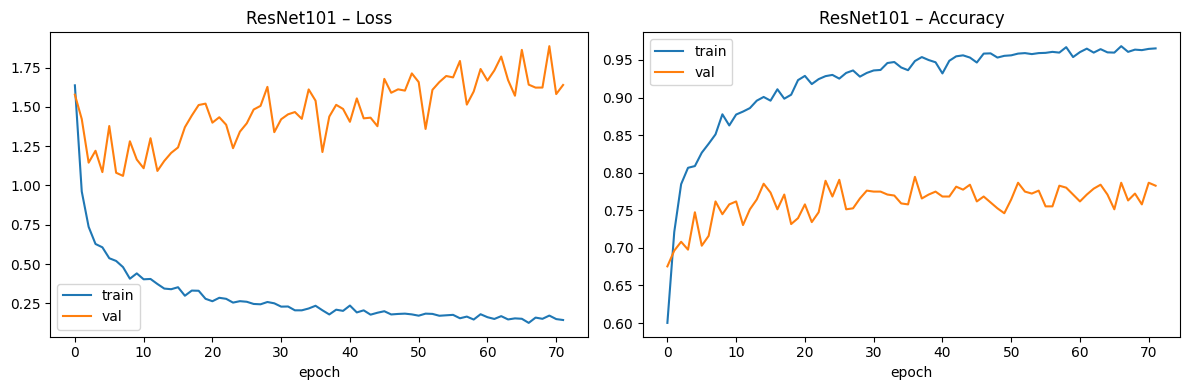


ResNet101 – Test acc: 0.7715  |  F1-score: 0.7716
                       precision    recall  f1-score   support

          1-Cardboard       0.64      0.85      0.73        93
      2-Food Organics       0.85      0.77      0.81        83
              3-Glass       0.67      0.67      0.67        84
              4-Metal       0.80      0.84      0.82       158
5-Miscellaneous Trash       0.66      0.58      0.62        99
              6-Paper       0.94      0.84      0.89       100
            7-Plastic       0.72      0.73      0.72       185
      8-Textile Trash       0.90      0.72      0.80        64
         9-Vegetation       0.88      0.93      0.91        88

             accuracy                           0.77       954
            macro avg       0.79      0.77      0.77       954
         weighted avg       0.78      0.77      0.77       954



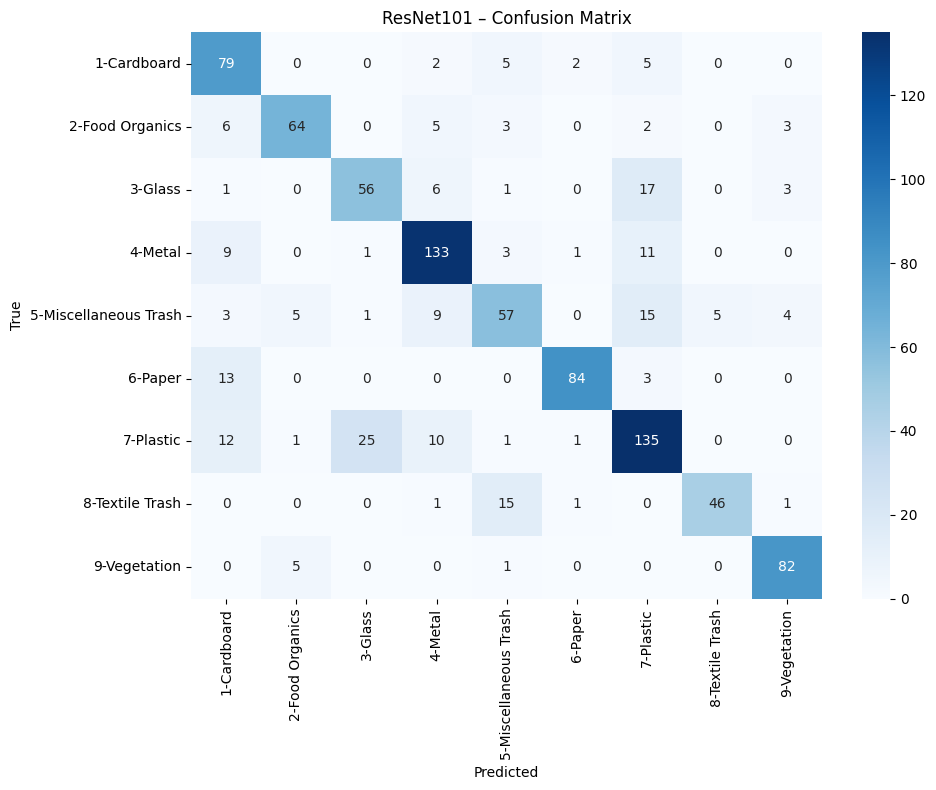

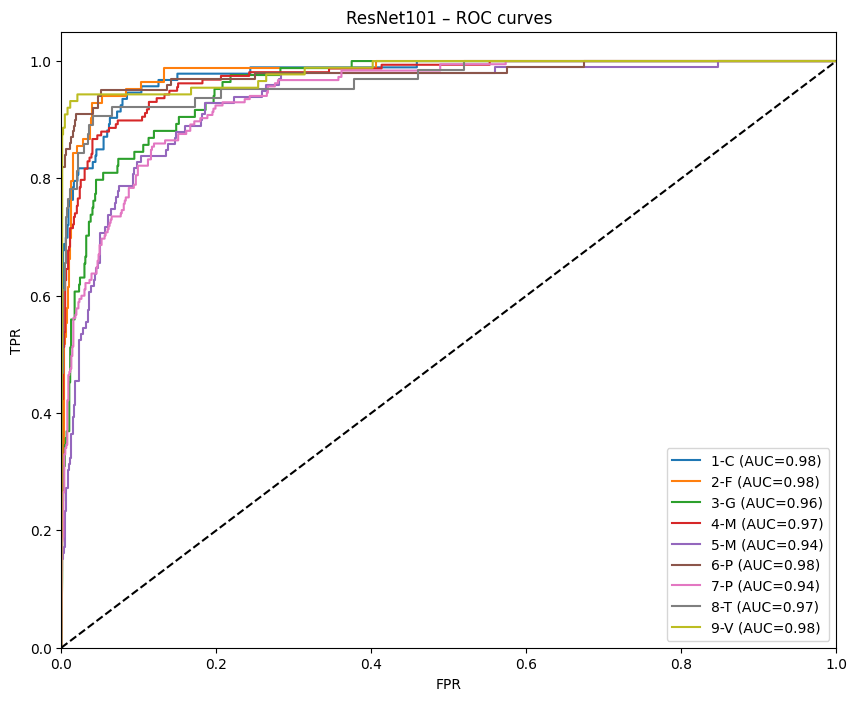


Training EfficientNetB0
Found 3034 images belonging to 9 classes.
Found 764 images belonging to 9 classes.
Found 954 images belonging to 9 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100

Epoch 1: val_loss improved from inf to 1.55305, saving model to best_EfficientNetB0.h5
607/607 - 91s - 150ms/step - accuracy: 0.6124 - loss: 1.4108 - val_accuracy: 0.6545 - val_loss: 1.5530
Epoch 2/100

Epoch 2: val_loss improved from 1.55305 to 1.25261, saving model to best_EfficientNetB0.h5
607/607 - 42s - 70ms/step - accuracy: 0.7350 - loss: 0.9031 - val_accuracy: 0.7147 - val_loss: 1.2526
Epoch 3/100

Epoch 3: val_loss improved from 1.25261 to 1.03796, saving model to best_EfficientNetB0.h5
607/607 - 42s - 70ms/step - accuracy: 0.7640 - loss: 0.7493 - val_accuracy: 0.7251 - val_loss: 1.0380
Epoch 4/100

Epoch 4: val_loss improved from 1.03796 to 0.99801, saving model to best_EfficientNetB0.h5
607/607 - 42s - 69ms/step - accuracy: 0.7900 - loss: 0.6494 - val_accuracy: 0.739

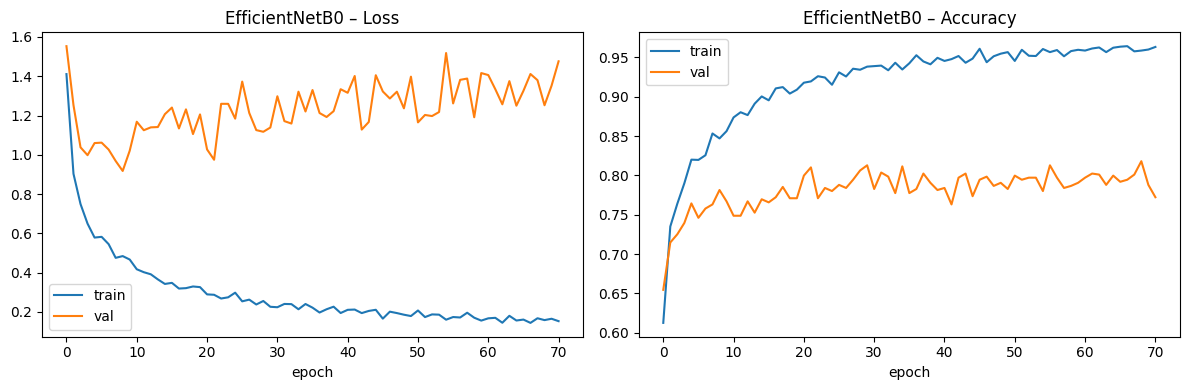


EfficientNetB0 – Test acc: 0.7914  |  F1-score: 0.7885
                       precision    recall  f1-score   support

          1-Cardboard       0.83      0.82      0.82        93
      2-Food Organics       0.72      0.77      0.74        83
              3-Glass       0.69      0.79      0.74        84
              4-Metal       0.77      0.92      0.84       158
5-Miscellaneous Trash       0.72      0.52      0.60        99
              6-Paper       0.85      0.89      0.87       100
            7-Plastic       0.85      0.74      0.79       185
      8-Textile Trash       0.71      0.77      0.74        64
         9-Vegetation       0.94      0.88      0.91        88

             accuracy                           0.79       954
            macro avg       0.79      0.79      0.78       954
         weighted avg       0.79      0.79      0.79       954



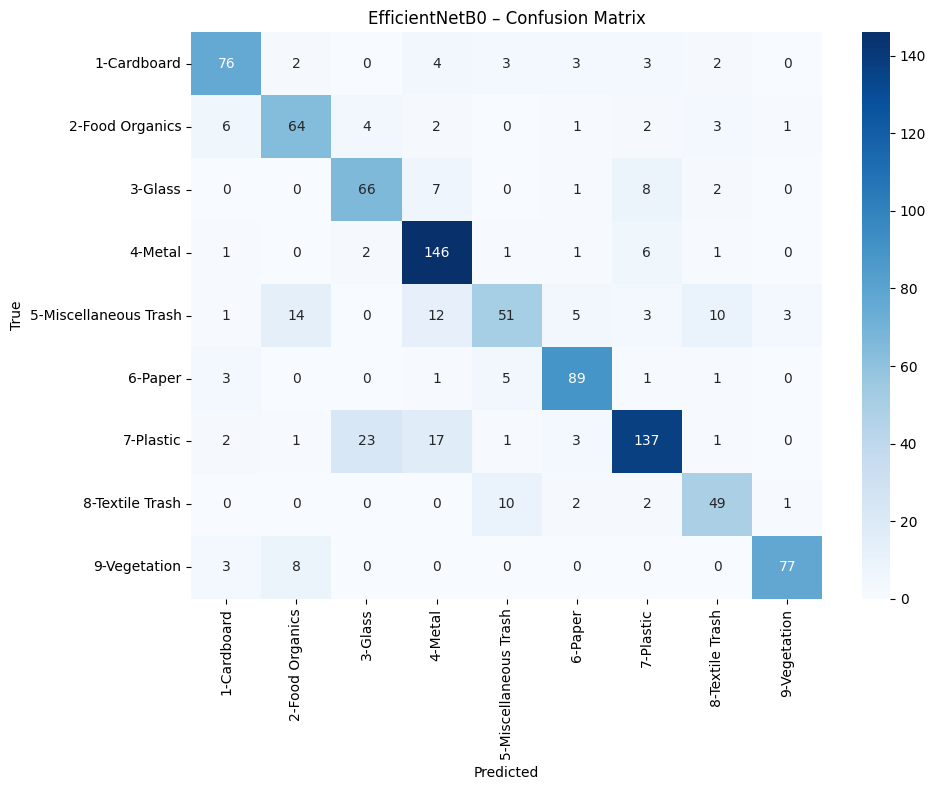

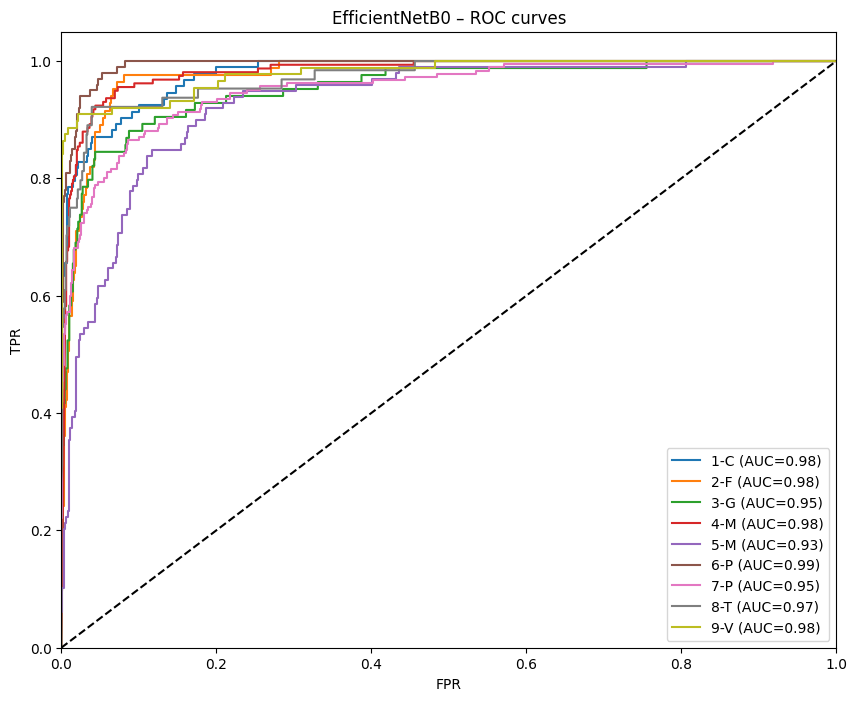


Training VGG16
Found 3034 images belonging to 9 classes.
Found 764 images belonging to 9 classes.
Found 954 images belonging to 9 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100

Epoch 1: val_loss improved from inf to 1.11105, saving model to best_VGG16.h5
607/607 - 51s - 84ms/step - accuracy: 0.5171 - loss: 1.5632 - val_accuracy: 0.6361 - val_loss: 1.1110
Epoch 2/100

Epoch 2: val_loss improved from 1.11105 to 1.10510, saving model to best_VGG16.h5
607/607 - 43s - 71ms/step - accuracy: 0.6391 - loss: 1.1225 - val_accuracy: 0.6872 - val_loss: 1.1051
Epoch 3/100

Epoch 3: val_loss improved from 1.10510 to 1.07986, saving model to best_VGG16.h5
607/607 - 43s - 71ms/step - accuracy: 0.6605 - loss: 1.0325 - val_accuracy: 0.6649 - val_loss: 1.0799
Epoch 4/100

Epoch 4: val_loss improved from 1.07986 to 1.04905, saving model to best_VGG16.h5
607/607 - 43s - 70ms/step - accuracy: 0.7037 - loss: 0.9150 - val_accuracy: 0.6558 - val_loss: 1.0490
Epoch 5/100

Epoch 5: val

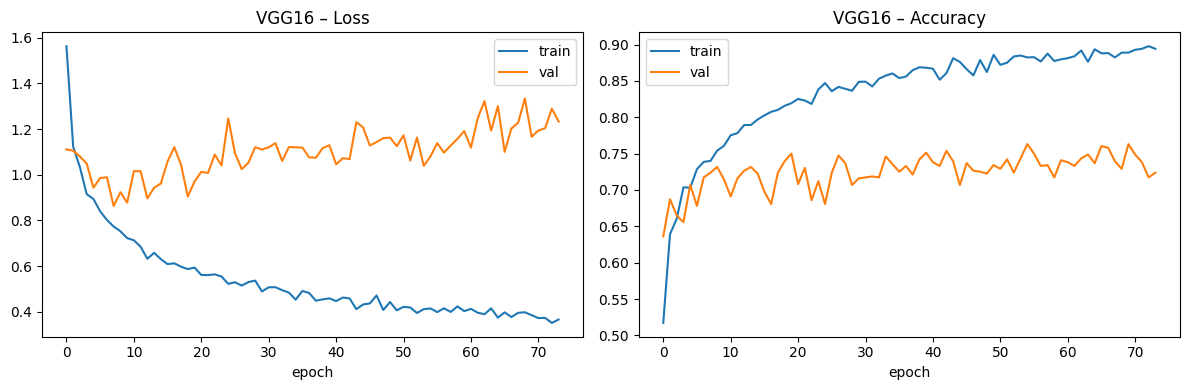


VGG16 – Test acc: 0.7736  |  F1-score: 0.7694
                       precision    recall  f1-score   support

          1-Cardboard       0.74      0.81      0.77        93
      2-Food Organics       0.73      0.77      0.75        83
              3-Glass       0.77      0.73      0.75        84
              4-Metal       0.73      0.87      0.79       158
5-Miscellaneous Trash       0.63      0.43      0.51        99
              6-Paper       0.88      0.84      0.86       100
            7-Plastic       0.77      0.79      0.78       185
      8-Textile Trash       0.86      0.77      0.81        64
         9-Vegetation       0.89      0.89      0.89        88

             accuracy                           0.77       954
            macro avg       0.78      0.77      0.77       954
         weighted avg       0.77      0.77      0.77       954



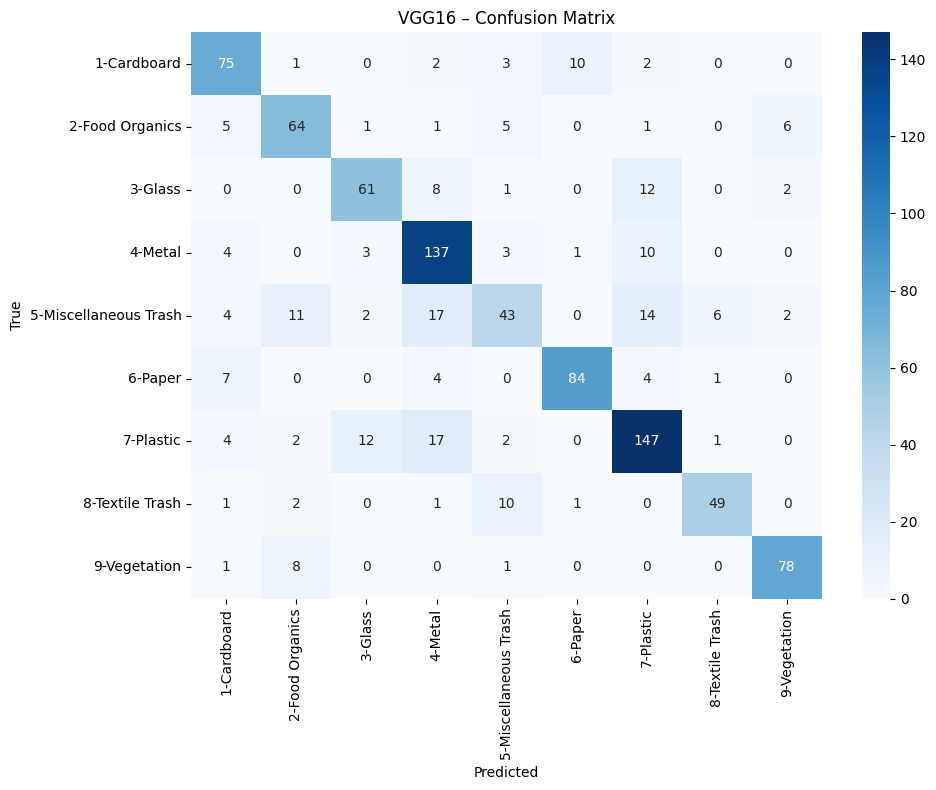

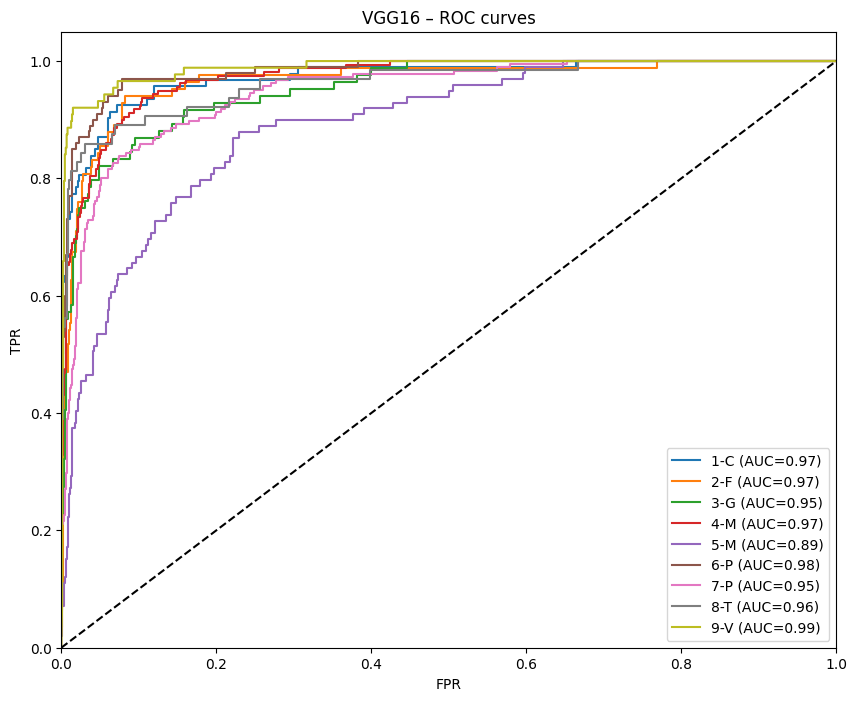

,test_accuracy,precision,recall,f1_score,mean_auc
ResNet50,0.77673,0.777459,0.77673,0.773595,0.961752
ResNet101,0.771488,0.777761,0.771488,0.771554,0.96597
EfficientNetB0,0.791405,0.793848,0.791405,0.788537,0.968413
VGG16,0.773585,0.771792,0.773585,0.769352,0.95934



Best model by F1-score ➜ EfficientNetB0


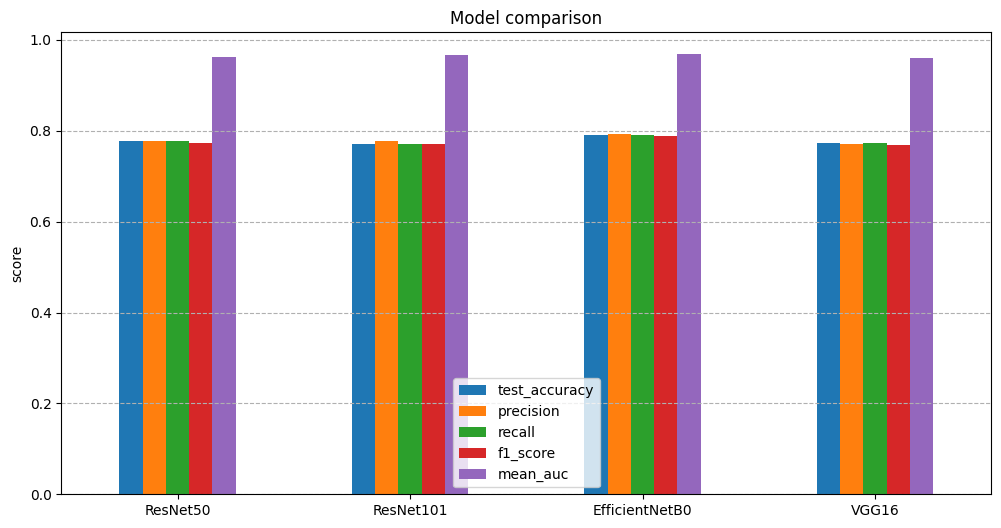

Results saved → model_comparison_results.csv


In [11]:

results = {}
models_to_run = ['ResNet50', 'ResNet101', 'EfficientNetB0', 'VGG16']
EPOCHS = 100

for m in models_to_run:
    print("\n" + "="*60 + f"\nTraining {m}\n" + "="*60)
    results[m] = train_and_evaluate_model(m, epochs=EPOCHS)

results_df = pd.DataFrame(results).T[['test_accuracy','precision','recall','f1_score','mean_auc']]
display(results_df)

best = results_df['f1_score'].idxmax()
print(f"\nBest model by F1-score ➜ {best}")


results_df.plot(kind='bar', figsize=(12,6))
plt.title('Model comparison'); plt.ylabel('score'); plt.xticks(rotation=0); plt.grid(axis='y',ls='--'); plt.show()


results_df.to_csv('model_comparison_results.csv', index=True)
print("Results saved → model_comparison_results.csv")


Is there a model that clearly outperforms others? <br>
 Across all key metrics—test accuracy (0.79 vs. ≈0.77), precision, recall, F1-score (0.79 vs. ≈0.77) and mean AUC (0.968 vs. ≤0.966)—EfficientNetB0 comes out on top, delivering a consistent ~1–2 percentage-point lift over the other backbones; while the gains aren’t huge, they are uniform across every metric, so EfficientNetB0 can be considered the best-performing model in this comparison.

### References:

https://www.google.com/url?q=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2020%2F10%2Fcreate-image-classification-model-python-keras%2F<br>
https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/<br>
https://www.geeksforgeeks.org/image-classification-using-resnet/<br>
https://keras.io/api/applications/<br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential<br>
https://keras.io/<br>
https://kili-technology.com/data-labeling/computer-vision/image-annotation/image-recognition-with-machine-learning-how-and-why<br>
https://docs.opencv.org/3.4/dc/dd6/ml_intro.html<br>
https://www.geeksforgeeks.org/opencv-overview/<br>
https://builtin.com/data-science/transfer-learning<br>
https://www.image-net.org/<br>
https://www.imagenetglobal.com/<br>
https://blog.roboflow.com/what-is-resnet-50/<br>
https://pytorch.org/vision/main/models/generated/torchvision.models.resnet101.html<br>
https://keras.io/api/applications/efficientnet/<br>
https://www.geeksforgeeks.org/vgg-16-cnn-model/<br>
https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/<br>
https://www.geeksforgeeks.org/adam-optimizer/<br>


### AI Prompts Used:

Explain me with example, how does Keras work?<br>
What is transfer learning, help me with understanding the use of it?<br>
What are the best practices for resizing or zero-padding images of different dimensions for deep learning in OpenCV or Keras?<br>
How does the ImageNet work and explain with simple example.<br>
Best parameters for image augmentation to improve model generalization without overfitting?<br>
There is error in this code, help me resolve this.<br>
Explain Adam optimizer and its importance.<br>
I want to run 50 epochs regardless, and then after 50 set patience?<br>
How can I improve my accuracy ? What are some of the ways to do this?<br>
Why is my transfer learning model overfitting, and how can I fix it?<br>
How to load pre-trained models in Keras and remove the last layer for feature extraction?<br>
